# Introduction: Formatting Data

In this notebook, we format data for document classification. These documents are Quora questions that need to be labeled sincere or insincere. We will format the data in two ways, into words, or into characters.

In [2]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

datadir = '/home/wjk68/data/quora/'

os.listdir(datadir)

['paragram_300_sl999',
 'GoogleNews-vectors-negative300',
 'wiki-news-300d-1M',
 'sample_submission.csv',
 'train.csv',
 'test.csv',
 'glove.840B.300d',
 'models']

In [3]:
train = pd.read_csv(datadir + 'train.csv')
texts = list(train['question_text'])
labels = list(train['target'])

test = pd.read_csv(datadir + 'test.csv')
test_texts = list(test['question_text'])

len(texts), len(test_texts)

(1306122, 56370)

In [7]:
def format_sequence(s):
    """Add spaces around punctuation."""

    # Add spaces around punctuation
    s = re.sub(
        r'(?<=[^\s])(?=[“”!\"#$%&()*+,./:;<=>?@[\]^_`{|}~\t\n])|(?=[^\s])(?<=[“”!\"#$%&()*+,./:;<=>?@[\]^_`{|}~\t\n])', r' ', s)

    # Remove double spaces
    s = re.sub(r'\s\s', ' ', s)
    return s

texts = [format_sequence(text) for text in texts]
test_texts = [format_sequence(text) for text in test_texts]

In [9]:
tokenizer = Tokenizer(lower = False, filters = '')
tokenizer.fit_on_texts(texts)
wc = tokenizer.word_counts
wc = sorted(wc.items(), key = lambda x: x[1], reverse = True)

keep_min = 5
keep = [count[0] for count in wc if count[1] >= keep_min]

print(f'There are {len(keep)} words with more than {keep_min} occurrences.')

There are 59727 words with more than 5 occurrences.


In [44]:
tokenizer = Tokenizer(num_words = len(keep), lower = False, 
                      filters = '', oov_token = 'UNK')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [28]:
word_index = dict(list(tokenizer.word_index.items())[:len(keep)])
word_index['PAD'] = 0
len(word_index), tokenizer.num_words

(59728, 59727)

In [29]:
index_word = dict(list(tokenizer.index_word.items())[:len(keep)])
index_word[0] = 'PAD'
vs = tokenizer.num_words + 1

In [30]:
word_index['UNK']

1

In [31]:
wc = tokenizer.word_counts
wc = sorted(wc.items(), key = lambda x: x[1], reverse = True)
wc[:15]

[('?', 1381190),
 ('the', 655017),
 ('What', 418491),
 ('to', 405796),
 ('a', 404386),
 ('in', 366895),
 ('is', 333568),
 ('of', 332834),
 ('I', 309502),
 ('How', 262904),
 ('and', 254031),
 (',', 235093),
 ('are', 213723),
 ('do', 212919),
 ('for', 201864)]

In [32]:
lens = [len(s) for s in sequences]
min(lens), max(lens)

(1, 503)

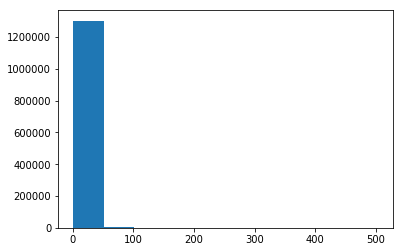

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lens);

In [34]:
pd.Series(lens).describe()

count    1.306122e+06
mean     1.443420e+01
std      7.912828e+00
min      1.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.700000e+01
max      5.030000e+02
dtype: float64

In [47]:
min_sequence_len = 8
max_sequence_len = 30
np.sum(np.array(lens) < min_sequence_len), np.sum(np.array(lens) > max_sequence_len)

(142121, 64938)

In [48]:
idx = [i for i, s in enumerate(sequences) if (len(s) >= min_sequence_len and len(s) <= max_sequence_len)]
len(idx)

1099063

In [49]:
sequences = pad_sequences(sequences, max_sequence_len)
test_sequences = pad_sequences(test_sequences, max_sequence_len)

seq_arr = np.array(sequences)[idx]
labels = np.array(labels)[idx]
test_seq_arr = np.array(test_sequences)

seq_arr.shape, test_seq_arr.shape

((1099063, 30), (56370, 30))

In [50]:
np.save('word_sequences.npy', seq_arr)
np.save('word_labels.npy', labels)
np.save('test_word_sequences.npy', test_seq_arr)

In [61]:
import json

with open('word_word_index.json', 'w') as f:
    f.write(json.dumps(word_index))
    
with open('word_index_word.json', 'w') as f:
    f.write(json.dumps(index_word))
    
with open('word_wc.json', 'w') as f:
    f.write(json.dumps(wc))

1068893

1188349

4928745

In [51]:
seq_arr = np.load('word_sequences.npy')
test_seq_arr = np.load('test_word_sequences.npy')
labels = np.load('word_labels.npy')

## Embeddings

In [52]:
EMBEDDING_FILE = datadir + 'glove.840B.300d/glove.840B.300d.txt'

In [53]:
!wc -l {EMBEDDING_FILE}

2196017 /home/wjk68/data/quora/glove.840B.300d/glove.840B.300d.txt


In [56]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

glove_embeddings_index = []

with open(EMBEDDING_FILE) as f:
    for i, l in enumerate(f):
        if (i + 1) % 10000 == 0:
            print(f'{100 * i / 2196017}% complete.', end = '\r')
        glove_embeddings_index.append(get_coefs(*l.split(" ")))
        
glove_embeddings_index = dict(glove_embeddings_index)

In [59]:
EMBEDDING_FILE = datadir + 'wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [ ]:
!wc -l {EMBEDDING_FILE}

In [60]:
wiki_embeddings_index = []

with open(EMBEDDING_FILE) as f:
    for i, l in enumerate(f):
        if (i + 1) % 10000 == 0:
            print(f'{100 * i / 9999995}% complete.', end = '\r')
        wiki_embeddings_index.append(get_coefs(*l.split(" ")))
        
wiki_embeddings_index = dict(wiki_embeddings_index)

### Embeddings into matrix

In [66]:
def create_embedding_matrix(word_index, embedding_index):
    
    embedding_matrix = np.random.normal(loc = 0, scale = 1/np.sqrt(vs), 
                                        size = (vs, embedding_index['the'].shape[0]))
    not_found = 0
    for i, word in enumerate(word_index.keys()):
        if (i + 1) % 10000 == 0:
            print(f'{100 * i / len(word_index)}% complete.', end = '\r')
        
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i, :] = vector
        else:
            not_found += 1
    
    print(not_found, ' words were not found.')
    return embedding_matrix

In [67]:
glove_embeddings = create_embedding_matrix(word_index, glove_embeddings_index)
glove_embeddings.shape

3132  words were not found.


(59728, 300)

In [69]:
wiki_embeddings = create_embedding_matrix(word_index, wiki_embeddings_index)
wiki_embeddings.shape

3601  words were not found...


(59728, 300)

In [70]:
np.save('word_glove_embeddings.npy', glove_embeddings)

In [71]:
np.save('word_wiki_embeddings.npy', wiki_embeddings)

## Function to Load in Data

In [76]:
def load_data(data_name, embedding_name):
    if embedding_name == 'wiki':
        if data_name == 'word':
            embedding_matrix = np.load('word_wiki_embeddings.npy')
    elif embedding_name == 'glove':
        if data_name == 'word':
            embedding_matrix = np.load('word_glove_embeddings.npy')
            
    if data_name == 'word':
        seq_arr = np.load('word_sequences.npy')
        test_seq_arr = np.load('test_word_sequences.npy')
        labels = np.load('word_labels.npy')
        iw = []
        with open('word_index_word.json', 'r') as f:
            for l in f:
                iw.append(json.loads(l))

        index_word = iw[0]
        index_word = {int(key): word for key, word in index_word.items()}

        wi = []
        with open('word_word_index.json', 'r') as f:
            for l in f:
                wi.append(json.loads(l))

        word_index = wi[0]
        word_index = {word: int(index) for word, index in word_index.items()}
            
        vs = len(word_index)
    return seq_arr, test_seq_arr, labels, word_index, index_word, vs, embedding_matrix

In [77]:
seq_arr, test_seq_arr, labels, word_index, index_word, vs, embedding_matrix = load_data('word', 'glove')
seq_arr.shape, test_seq_arr.shape, embedding_matrix.shape

((1099063, 30), (56370, 30))

# Character Level Embeddings

Next we'll look at embedding the data as characters. We can use the same Tokenizer method.

In [6]:
tokenizer = Tokenizer(filters = '', lower = False, char_level = True)
tokenizer.fit_on_texts(texts)

wc = tokenizer.word_counts
wc = sorted(wc.items(), key = lambda x: x[1], reverse = True)

keep_min = 10
keep = [count[0] for count in wc if count[1] >= keep_min]

print(f'There are {len(keep)} characters with more than {keep_min} occurrences.')

There are 322 characters with more than 10 occurrences.


In [29]:
tokenizer = Tokenizer(num_words = len(keep), lower = False,
                      char_level = True,
                      filters = '', oov_token = 'UNK')
tokenizer.fit_on_texts(texts)
chars = tokenizer.texts_to_sequences(texts)
test_chars = tokenizer.texts_to_sequences(test_texts)

len(chars), len(test_chars)

(1306122, 56370)

In [ ]:
word_index = dict(list(tokenizer.word_index.items())[:len(keep)])
word_index['PAD'] = 0
len(word_index), tokenizer.num_words

(323, 322)

In [ ]:
index_word = dict(list(tokenizer.index_word.items())[:len(keep)])
index_word[0] = 'PAD'
vs = tokenizer.num_words + 1

In [ ]:
wc = tokenizer.word_counts
wc = sorted(wc.items(), key = lambda x: x[1], reverse = True)
wc[:15]

In [ ]:
lens = [len(s) for s in chars]
min(lens), max(lens)

In [ ]:
min_char_len = 30
max_char_len = 150

np.sum(np.array(lens) < min_char_len), np.sum(np.array(lens) > max_char_len)

In [ ]:
idx = [i for i, c in enumerate(chars) if (len(c) >= min_char_len and len(c) <= max_char_len)]
len(idx)

In [ ]:
chars = pad_sequences(chars, max_char_len)
test_chars = pad_sequences(test_chars, max_char_len)

chars = chars[idx]
labels = np.array(labels)[idx]

chars.shape, test_chars.shape

In [ ]:
np.save('char_sequences.npy', chars)
np.save('char_labels.npy', labels)
np.save('test_char_sequences.npy', test_chars)

In [ ]:
import json

with open('char_word_index.json', 'w') as f:
    f.write(json.dumps(word_index))
    
with open('char_index_word.json', 'w') as f:
    f.write(json.dumps(index_word))
    
with open('char_wc.json', 'w') as f:
    f.write(json.dumps(wc))